In [ ]:
!pip install pandas
!pip install matplotlib
!pip install statsmodels
!pip install numpy

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
from statsmodels.tsa.arima.model import ARIMA
sys.path.append("..")
from src.forecast import generate_forecast_data

In [2]:
df =pd.read_csv("../data/raw/stock_data_cleaned.csv")

In [3]:
df.columns.tolist()

['Date', 'BND', 'SPY', 'TSLA']

In [4]:
best_order = (0, 1, 0) 
arima_model = ARIMA(df['TSLA'], order=best_order).fit()


In [9]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True) # <--- 'inplace=True' makes the change permanent
# 3. Handle Business Day frequency (Crucial for stocks)
df = df.asfreq('B')
df['TSLA'] = df['TSLA'].ffill()
# --- VERIFICATION STEP ---
# This will stop the code if the index isn't a Date yet
if not isinstance(df.index, pd.DatetimeIndex):
    print("Index is still not a Date! Attempting manual override...")
    df.index = pd.to_datetime(df.index)

In [10]:
forecast, conf_int = generate_forecast_data(arima_model, steps=252)
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=252, freq='B')

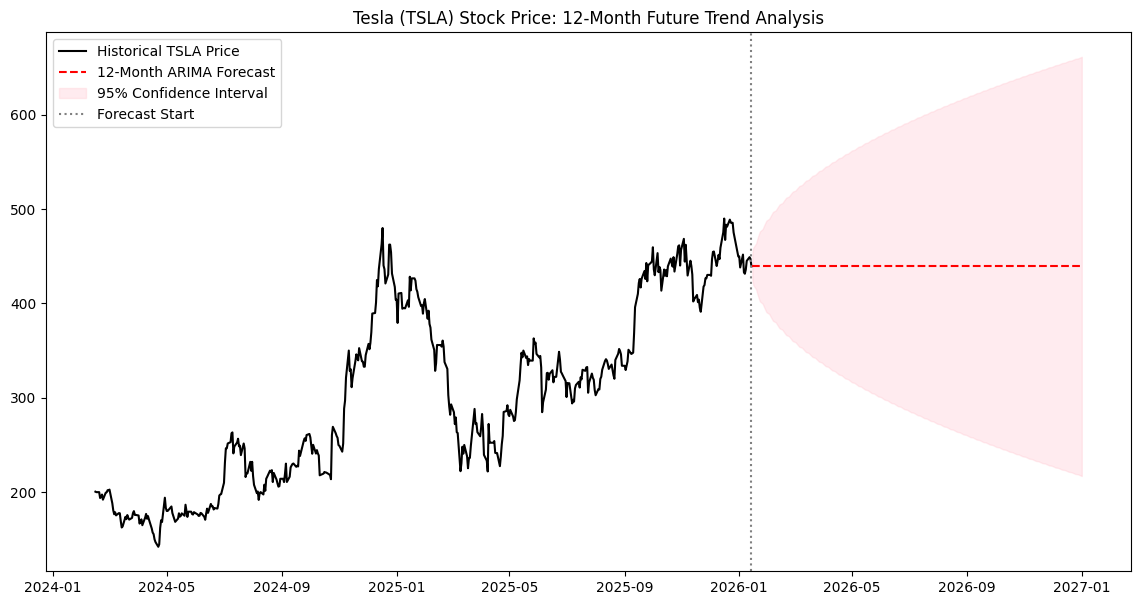

In [11]:
plt.figure(figsize=(14, 7))
plt.plot(df.index[-500:], df['TSLA'].tail(500), label='Historical TSLA Price', color='black')
plt.plot(future_dates, forecast, label='12-Month ARIMA Forecast', color='red', linestyle='--')

plt.fill_between(future_dates, conf_int.iloc[:, 0], conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.axvline(x=last_date, color='gray', linestyle=':', label='Forecast Start')
plt.title("Tesla (TSLA) Stock Price: 12-Month Future Trend Analysis")
plt.legend()
plt.show() 


### 1. The Long-Term Trend (The Red Dashed Line)
This line is the "signal" the ARIMA model has extracted from historical data.

Upward Slope: Indicates a Bullish outlook, suggesting the stock has historical momentum to continue growing.
Downward Slope: Indicates a Bearish outlook, suggesting the model expects the price to decline based on recent patterns.
Flat Line: Suggests Stagnation or a "sideways" market where the price is expected to stay within a specific range.

### 2. The "Uncertainty Cone" (The Shaded Area)
The shaded region represents the 95% Confidence Interval.
Widening Shape:the shaded area is narrow at the start and gets much wider by Month 12. This is called the "Fan Effect".

What it means: It mathematically shows that uncertainty increases as you forecast further out. The model is essentially saying, "I'm fairly sure about next week, but by next year, the price could be anywhere in this wide range".

### 3. Market Opportunities and Risks
Opportunity: If the red dashed line is trending up and the current price is at the bottom of the shaded area, it might signal a statistical buying opportunity.

Risk: The large width of the shaded area at the 12-month mark highlights the volatility risk. It warns  that a long-term investment has a wide range of possible outcomes, some of which may be below your entry price.

In [13]:
print("   12-MONTH PRICE PROJECTIONS")
print(f"Predicted Price: ${forecast.iloc[-1]:.2f}")
print(f"Bull Case (Max): ${conf_int.iloc[-1, 1]:.2f}")
print(f"Bear Case (Min): ${conf_int.iloc[-1, 0]:.2f}")


   12-MONTH PRICE PROJECTIONS
Predicted Price: $439.20
Bull Case (Max): $661.33
Bear Case (Min): $217.07
